<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/bonespect_train_20231031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from glob import glob
import numpy as np
import cv2, os, copy, shutil
import matplotlib.pyplot as plt
from PIL import Image
from random import randint

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model
from skimage.metrics import structural_similarity as ssim



In [2]:
inputNpyList = sorted(glob("/content/drive/MyDrive/Bone_SPECT/inputData/*.npy"))
labelNpyList = sorted(glob("/content/drive/MyDrive/Bone_SPECT/cleanLabelData/*.npy"))

In [3]:
inputNpyList[0]

'/content/drive/MyDrive/Bone_SPECT/inputData/23050201_input.npy'

In [4]:
testImg = np.load(inputNpyList[0])

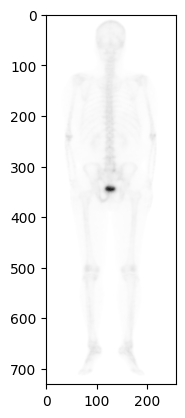

In [5]:
plt.imshow(testImg, cmap='gray_r')
plt.show()

In [6]:
print(inputNpyList[0], labelNpyList[0])

/content/drive/MyDrive/Bone_SPECT/inputData/23050201_input.npy /content/drive/MyDrive/Bone_SPECT/cleanLabelData/23050201_modLabel.npy


In [7]:
for i in range(238):
    tempInput = inputNpyList[i].split("/")[-1][:8]
    tempLabel = labelNpyList[i].split("/")[-1][:8]
    if tempInput != tempLabel:
        print(i)
    else:
        continue

In [8]:
inputObj = []
labelObj = []
sizesImg = []

for i in range(238):
    tempInputObj = np.load(inputNpyList[i])
    tempInputObj = np.array(tempInputObj, dtype=np.uint16)
    tempLabelObj = np.load(labelNpyList[i])
    tempLabelObj = np.array(tempLabelObj, dtype=np.uint16)
    sizesImg.append(np.shape(tempInputObj)[0])
    inputObj.append(tempInputObj)
    labelObj.append(tempLabelObj)

In [9]:
MAX_SIZE = 1024

In [10]:
train_imgs = []
train_lbls = []

In [11]:
for i in range(238):
    io_x, ioy = np.shape(inputObj[i])
    if io_x != MAX_SIZE:
        diffIOx = MAX_SIZE - io_x
        zeroPadding = np.zeros((diffIOx,256))
        tempInput = np.vstack([inputObj[i],zeroPadding])
        tempLabel = np.vstack([labelObj[i],zeroPadding])
        train_imgs.append(tempInput)
        train_lbls.append(tempLabel)
    else:
        train_imgs.append(inputObj[i])
        train_lbls.append(labelObj[i])

In [12]:
temp_train_imgs = np.array(train_imgs)
temp_train_lbls = np.array(train_lbls)

In [13]:
temp_train_lbls[temp_train_lbls >=1] = 1

In [14]:
split_num = 200

In [15]:
train_imgs = temp_train_imgs[:split_num,...]
valid_imgs = temp_train_imgs[split_num:,...]
train_msks = temp_train_lbls[:split_num,...]
valid_msks = temp_train_lbls[split_num:,...]

In [16]:
train_imgs = np.array(train_imgs, dtype=np.float32)
train_msks = np.array(train_msks, dtype=np.float32)
valid_imgs = np.array(valid_imgs, dtype=np.float32)
valid_msks = np.array(valid_msks, dtype=np.float32)

train_msks = np.reshape(train_msks, (*train_msks.shape, 1))
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_msks))

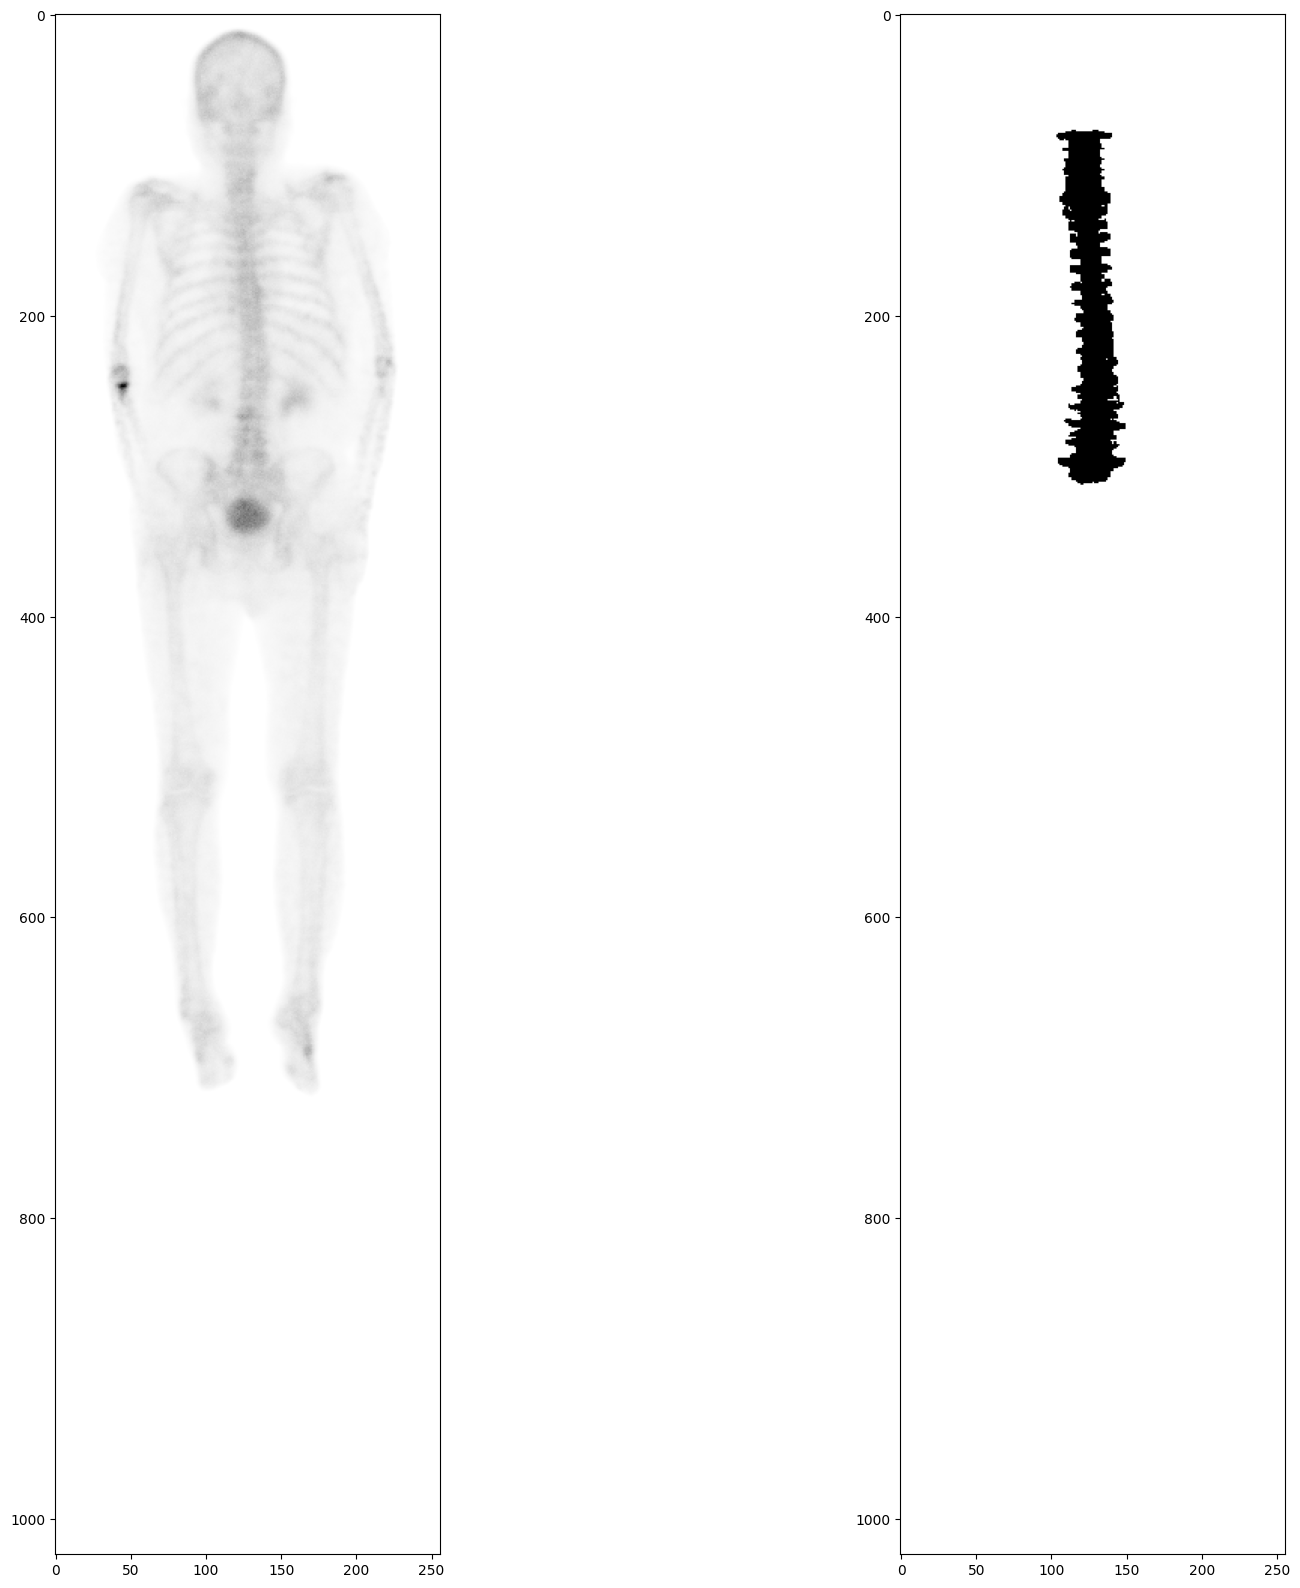

In [17]:
%matplotlib inline

rand_num = randint(1,len(train_imgs))

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[rand_num], cmap='gray_r')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_msks[rand_num]), cmap='gray_r')

In [18]:
test_img = train_imgs[10] * np.squeeze(train_msks[10])

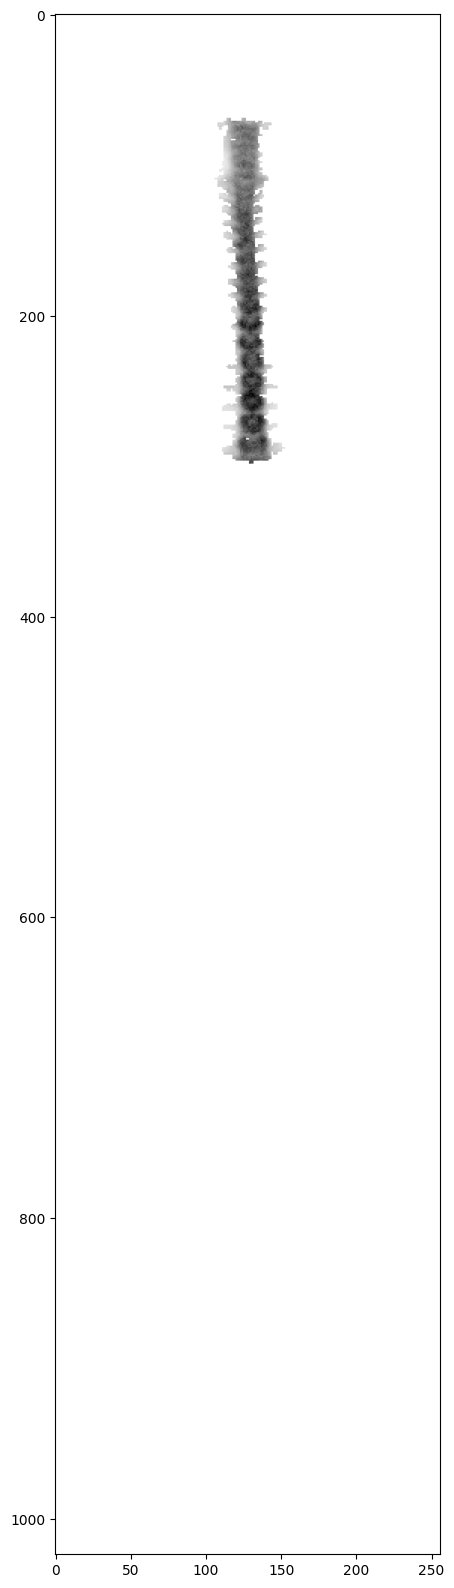

In [19]:
plt.figure(0, figsize=(20, 20))
plt.imshow(test_img, cmap="gray_r")
plt.show()

In [20]:
inputs = Input((MAX_SIZE, 256, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)



In [21]:
model = Model(inputs=[inputs], outputs=[conv10])

In [22]:
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0

In [23]:
initial_learning_rate = 5e-6

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Bone_SPECT/models/mymodel_{epoch}.h5",
    save_best_only=True,
    monitor='val_loss',
    verbose=1)]

In [24]:
model.compile(Adam(learning_rate=lr_schedule), bce_dice_loss, metrics=[binary_crossentropy, generalized_dice_coefficient])

In [25]:
model.fit(train_imgs, train_msks, batch_size=10, epochs=200, callbacks=callbacks, validation_data=(valid_imgs, valid_msks))

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.8200 - binary_crossentropy: 0.6742 - generalized_dice_coefficient: 0.0342
Epoch 1: val_loss improved from inf to 0.82053, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 20s 338ms/step - loss: 0.8200 - binary_crossentropy: 0.6742 - generalized_dice_coefficient: 0.0342 - val_loss: 0.8205 - val_binary_crossentropy: 0.6676 - val_generalized_dice_coefficient: 0.0265
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.8187 - binary_crossentropy: 0.6712 - generalized_dice_coefficient: 0.0339
Epoch 2: val_loss improved from 0.82053 to 0.82013, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_2.h5
20/20 [==============================] - 4s 223ms/step - loss: 0.8187 - binary_crossentropy: 0.6712 - generalized_dice_coefficient: 0.0339 - val_loss: 0.8201 - val_binary_crossentropy: 0.6682 - val_generalized_dice_coefficient: 0.0279
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.8174 - binary_crossentropy: 0.6682 - generalized_dice_coefficient: 0.0335
Epoch 3: val_loss improved from 0.82013 to 0.81905, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_

In [26]:
np.shape(train_imgs[0])

(1024, 256)

In [27]:
prediction = np.array([train_imgs[0]])

In [28]:
pred_img = model.predict(prediction)

1/1 [==============================] - 1s 711ms/step


In [29]:
np.shape(pred_img)

(1, 1024, 256, 1)

In [30]:
pltImg = np.squeeze(pred_img)

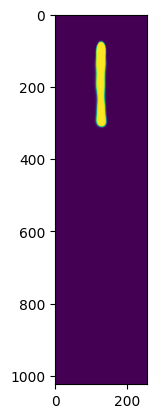

In [31]:
plt.imshow(pltImg)
plt.show()

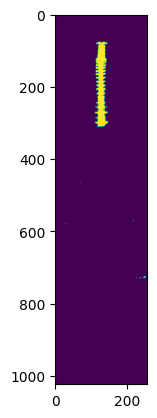

In [32]:
plt.imshow(train_msks[0])
plt.show()

In [33]:
srcPath = "/content/drive/MyDrive/Bone_SPECT/upload.zip"
dstPath = "/content/drive/MyDrive/Bone_SPECT"

import zipfile

with zipfile.ZipFile(srcPath, 'r') as zip_ref:
    zip_ref.extractall(dstPath)

In [34]:
predImgPath = "/content/drive/MyDrive/Bone_SPECT/23050201_inputData.npz"
testImg = np.load(predImgPath)['arr_0']

In [35]:
print(np.shape(testImg))

(731, 256)


In [36]:
padding_size = MAX_SIZE - np.shape(testImg)[0]

In [37]:
padding_size

293

In [38]:
padding_array = np.zeros((293,256))

In [39]:
outImg = np.vstack([testImg,padding_array])

In [40]:
np.shape(outImg)

(1024, 256)

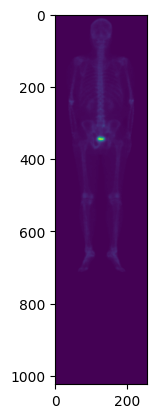

In [41]:
plt.imshow(outImg)

In [42]:
from tensorflow.keras.models import load_model

root = "/content/drive/MyDrive/Bone_SPECT/models/mymodel_193.h5"

custom_objects = {"dice_coef":dice_coef, "generalized_dice_coefficient":generalized_dice_coefficient,"dice_loss":dice_loss,"bce_dice_loss":bce_dice_loss}

with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model(root)

In [43]:
pred_img = model.predict(np.array([outImg]))

1/1 [==============================] - 0s 236ms/step


In [44]:
pltImg = np.squeeze(pred_img)

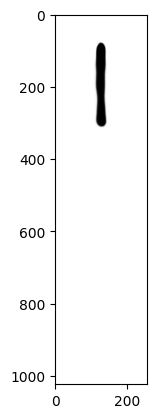

In [45]:
plt.imshow(pltImg, cmap='gray_r')

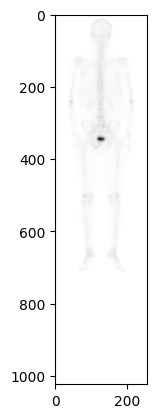

In [46]:
plt.imshow(outImg,cmap='gray_r')

In [47]:
import numpy as np
import matplotlib.pyplot as plt

inputPath = "/content/drive/MyDrive/Bone_SPECT/23050201_labelData.npy"

img = np.load(inputPath)

In [48]:
np.shape(img)

(731, 256)

In [49]:
padding_array = np.zeros((293,256))
outImg = np.vstack([img,padding_array])

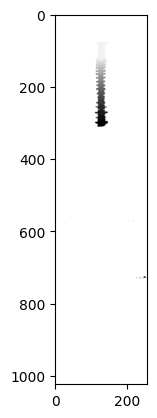

In [50]:
plt.imshow(outImg, cmap='gray_r')

In [ ]:
outImg[outImg >=1]=1

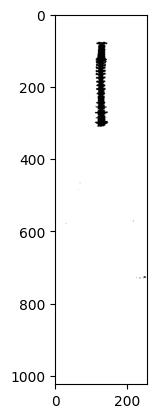

In [ ]:
plt.imshow(outImg, cmap='gray_r')

In [ ]:
outImg = outImg[:,::-1]

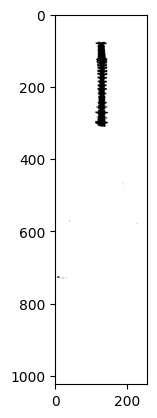

In [ ]:
plt.imshow(outImg, cmap='gray_r')

In [53]:
for layer in model.layers:
    print(layer.get_weights())

[]
[array([1.0043972], dtype=float32), array([0.00219797], dtype=float32), array([663.1576], dtype=float32), array([2941108.2], dtype=float32)]
[array([[[[ 0.10448831,  0.06579394, -0.02696662,  0.10911102,
           0.1078819 ,  0.0718199 ,  0.11976968, -0.01222219,
           0.08386242,  0.0809478 , -0.03917022,  0.06082156,
          -0.06717755, -0.13523506, -0.14206249,  0.0344814 ,
          -0.13925299,  0.10793593, -0.03426882, -0.03621838,
           0.06031445, -0.06366792, -0.11036877,  0.0450861 ,
           0.12201463,  0.00623411, -0.08857784,  0.10699169,
          -0.02039512, -0.10872412, -0.0854768 ,  0.10646479]],

        [[ 0.10759279,  0.1411845 ,  0.04929547,  0.09923423,
           0.07104369,  0.10740779,  0.00309789,  0.01734226,
          -0.08569735,  0.01530693, -0.12625512,  0.0118441 ,
           0.05384736, -0.12899734,  0.00145194, -0.01802177,
          -0.02320225, -0.06104671,  0.0417869 ,  0.09999151,
           0.0324592 , -0.02931751, -0.0208629

In [54]:
dir(model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__annotations__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_aggregate_exact_metrics',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_check_call_args',
 '_check_sample_weight_warning'

In [59]:
print(model.get_weights())

[array([1.0043972], dtype=float32), array([0.00219797], dtype=float32), array([663.1576], dtype=float32), array([2941108.2], dtype=float32), array([[[[ 0.10448831,  0.06579394, -0.02696662,  0.10911102,
           0.1078819 ,  0.0718199 ,  0.11976968, -0.01222219,
           0.08386242,  0.0809478 , -0.03917022,  0.06082156,
          -0.06717755, -0.13523506, -0.14206249,  0.0344814 ,
          -0.13925299,  0.10793593, -0.03426882, -0.03621838,
           0.06031445, -0.06366792, -0.11036877,  0.0450861 ,
           0.12201463,  0.00623411, -0.08857784,  0.10699169,
          -0.02039512, -0.10872412, -0.0854768 ,  0.10646479]],

        [[ 0.10759279,  0.1411845 ,  0.04929547,  0.09923423,
           0.07104369,  0.10740779,  0.00309789,  0.01734226,
          -0.08569735,  0.01530693, -0.12625512,  0.0118441 ,
           0.05384736, -0.12899734,  0.00145194, -0.01802177,
          -0.02320225, -0.06104671,  0.0417869 ,  0.09999151,
           0.0324592 , -0.02931751, -0.02086294, -

In [ ]:
!pip install pydicom
import numpy as np
import pydicom
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00


In [51]:
path = "/content/drive/MyDrive/Bone_SPECT/nm630test.dcm"

In [52]:
fObj = pydicom.dcmread(path)
arrObj = fObj.pixel_array[1]
pred_img = model.predict(np.array([arrObj]))

NameError: ignored

In [ ]:
np.shape(pred_img)

(1, 1024, 256, 1)

In [ ]:
plt_img = np.squeeze(pred_img)

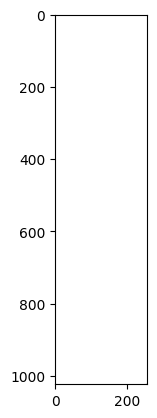

In [ ]:
plt.imshow(plt_img, cmap='gray_r')

In [ ]:
np.max(arrObj)

89

In [ ]:
arrObj = arrObj * 400

In [ ]:
np.max(arrObj)

35600

In [ ]:
arrObj = arrObj / 10

In [ ]:
np.max(arrObj)

3560.0

In [ ]:
arrObj = arrObj*10

In [ ]:
pred_img = model.predict(np.array([arrObj]))

1/1 [==============================] - 0s 289ms/step


In [ ]:
np.shape(pred_img)

(1, 1024, 256, 1)

In [ ]:
plt_img = np.squeeze(pred_img)

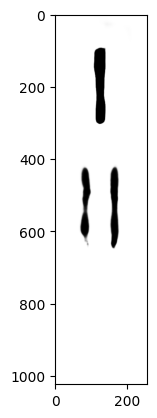

In [ ]:
plt.imshow(plt_img, cmap='gray_r')

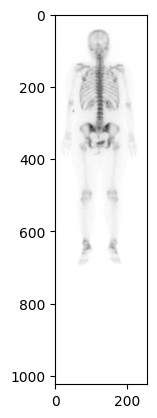

In [ ]:
plt.imshow(arrObj,cmap='gray_r')